In [1715]:
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import yaml
import matplotlib.pyplot as plt

In [1716]:
RUN = "20231025-zecm"


In [1717]:

matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
config_fn = "../../config/config.yaml"

plt.style.use(["bmh", matplotlibrc_fn])

with open(config_fn, "r") as f:
    config = yaml.safe_load(f)

tech_colors = config["plotting"]["tech_colors"]

# for EU: https://ec.europa.eu/eurostat/databrowser/view/prc_hicp_aind__custom_9900786/default/table?lang=en
EUR_2015_TO_2020 = (1.002*1.017*1.019*1.015*1.007)
EUR_2015_TO_2020

1.0613493817548298

In [1718]:
fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc"

In [1719]:
ni = pypsa.Network(fn)

INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [1720]:
NICE_NAMES = {
    "import pipeline-h2": "hydrogen",
    "import shipping-lh2": "hydrogen (ship)",
    "import shipping-ftfuel": "Fischer-Tropsch",
    "import shipping-meoh": "methanol",
    "import shipping-lch4": "methane",
    "import shipping-lnh3": "ammonia",
    "import shipping-steel": "steel",
}

min_import_costs = pd.concat([
    ni.generators.filter(like="import", axis=0).groupby("carrier").marginal_cost.describe(),
    ni.links.filter(like="import", axis=0).groupby("carrier").marginal_cost.describe(),
])
min_import_costs = min_import_costs[["min", "max"]].rename(index=NICE_NAMES).drop("import hvdc-to-elec")
min_import_costs *= EUR_2015_TO_2020
min_import_costs

min         max
carrier                                
hydrogen          57.530634   69.619810
hydrogen (ship)   83.337937   89.932972
ammonia           87.687251   87.687251
steel            500.693625  500.693625
Fischer-Tropsch  109.847302  109.847302
methane          103.917310  104.736334
methanol         106.769426  106.769426

In [1729]:
scenarios_fn = {
 "imp+H2": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+H2_2050.nc",
 "imp": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc",
 "noimp": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5_2050.nc",
}

scenario_name = "noimp"

fn = scenarios_fn[scenario_name]

In [1730]:
n = pypsa.Network(fn)
n.buses_t.marginal_price *= EUR_2015_TO_2020
n.lines["capital_cost"] *= EUR_2015_TO_2020
for c in n.iterate_components({"Generator", "Store", "Link", "StorageUnit"}):
    c.df.marginal_cost *= EUR_2015_TO_2020

INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [1733]:
x = n.statistics.energy_balance().xs("co2 stored", level='bus_carrier').div(1e6).round(1).sort_values()
x.where(x>0).sum() -4

597.5

In [1632]:
ac_prices = n.buses_t.marginal_price.loc[:, (n.buses.carrier == "AC") & (n.buses.index.str.len() != 2)]
h2_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "H2"].rename(columns=n.buses.location)
gas_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "gas"].rename(columns=n.buses.location)
heat_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "urban central heat"].rename(columns=n.buses.location)
nh3_prices = n.buses_t.marginal_price["EU NH3"]
oil_prices = n.buses_t.marginal_price["EU oil"]
steel_prices = n.buses_t.marginal_price["EU steel"]
meoh_prices = n.buses_t.marginal_price["EU methanol"]
co2_prices = n.buses_t.marginal_price["co2 stored"]
co2_tax = n.buses_t.marginal_price["co2 atmosphere"]

## Breakdown electrolyser market value

In [1633]:
mapper = n.links.bus1.map(n.buses.location)
carrier = "H2 Electrolysis"
threshold = 1
weights = n.snapshot_weightings.generators

In [1634]:
electrolysers = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [1635]:

electrolysers_capex = electrolysers.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [1636]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
electrolysers_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
electrolysers_h2 = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
electrolysers_heat = -n.links_t.p2.loc[:, sel].rename(columns=mapper)

In [1637]:
electrolysers_h2_output = weights @ electrolysers_h2

In [1638]:
## start time series

In [1639]:
electrolysers_ac_cost_t = (ac_prices[electrolysers.index] * electrolysers_ac) / electrolysers_h2
electrolysers_heat_revenue_t = (heat_prices[electrolysers.index] * electrolysers_heat) / electrolysers_h2
electrolysers_capex_t = (electrolysers_capex * electrolysers_h2.mul(weights, axis=0).div(electrolysers_h2_output)) / electrolysers_h2_output

In [1640]:
electrolysers_cost_t = (electrolysers_ac_cost_t + electrolysers_heat_revenue_t + electrolysers_capex_t)

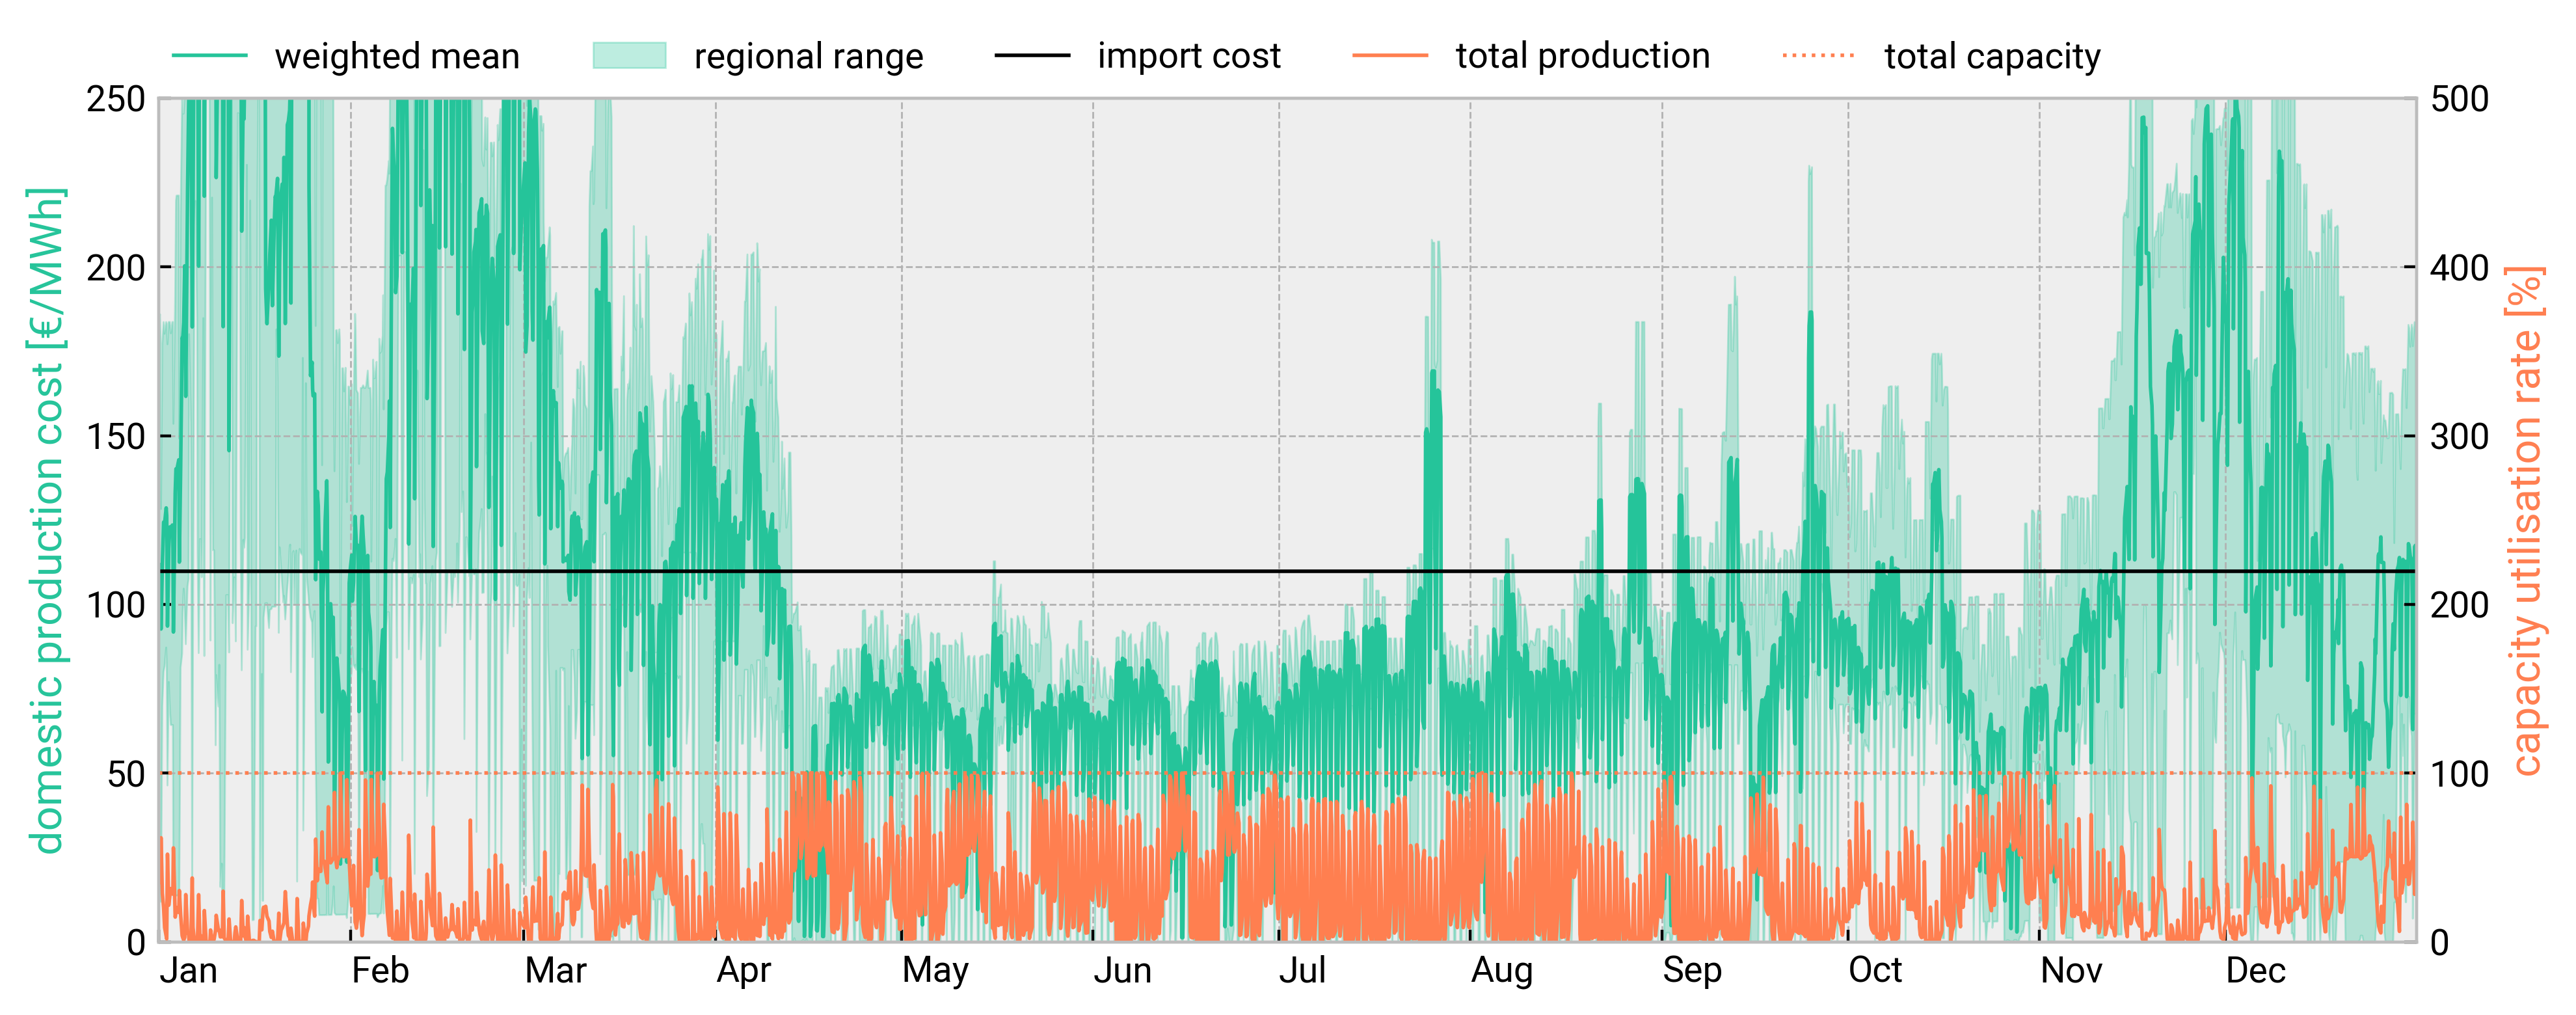

In [1641]:
mean_values = (electrolysers_cost_t * electrolysers_h2_output).sum(axis=1) / electrolysers_h2_output.sum()
min_values = electrolysers_cost_t.min(axis=1)
max_values = electrolysers_cost_t.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

mean_values.plot(ax=ax, label="weighted mean", color=tech_colors["Fischer-Tropsch"], linewidth=1)
plt.fill_between(electrolysers_cost_t.index, min_values, max_values, color=tech_colors["Fischer-Tropsch"], alpha=0.3, label='regional range')

ax.axhline(min_import_costs.at["Fischer-Tropsch", "min"], color="black", lw=1, label="import cost")


ax_twin = ax.twinx()

total_capacity = electrolysers.eval("p_nom_opt * efficiency").sum()

electrolysers_h2.sum(axis=1).div(total_capacity).mul(100).plot(ax=ax_twin, linewidth=1, color="coral", label="total production")

ax_twin.axhline(100, lw=1, label="total capacity", linestyle=":", color='coral')

ax_twin.grid(False)

ax_twin.set_ylim(0, 500)

ax_twin.set_ylabel("capacity utilisation rate [%]", color="coral")


import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for label in ax.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax.set_ylim(0, 250)

ax.set_ylabel('domestic production cost [€/MWh]', color=tech_colors["Fischer-Tropsch"])
ax.set_xlabel("")
ax.set_xlim("2013-01-01 00:00", "2013-12-31 23:00");

handles, labels = [], []
for ax in [ax, ax_twin]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single combined legend
plt.legend(handles, labels, ncol=5, loc=(0, 1.01))

plt.savefig(f"electrolysers-t-{scenario_name}.png")

In [1642]:
# end time series

In [1643]:
electrolysers_ac_cost = weights @ (ac_prices[electrolysers.index] * electrolysers_ac)
electrolysers_h2_revenue = weights @ (h2_prices[electrolysers.index] * electrolysers_h2)
electrolysers_heat_revenue = weights @ (heat_prices[electrolysers.index] * electrolysers_heat)

In [1644]:
electrolysers_cost = (electrolysers_ac_cost + electrolysers_capex - electrolysers_heat_revenue) / electrolysers_h2_output

In [1645]:
electrolysers_revenue = electrolysers_h2_revenue / electrolysers_h2_output

In [1646]:
electrolysers_balance = pd.DataFrame({
    "electricity cost": electrolysers_ac_cost,
    "investment cost": electrolysers_capex,
    "heat revenue": -electrolysers_heat_revenue,
    "product revenue": -electrolysers_h2_revenue
}).div(electrolysers_h2_output, axis=0)

electrolysers_balance = pd.Series(
    np.average(electrolysers_balance, weights=electrolysers_h2_output, axis=0),
    index=electrolysers_balance.columns
)
electrolysers_balance

electricity cost    43.196201
investment cost     22.674914
heat revenue        -5.689835
product revenue    -61.587823
dtype: float64

## Breakdown Haber-Bosch market value

In [1647]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Haber-Bosch"
threshold = 1
weights = n.snapshot_weightings.generators

In [1648]:
haberbosch = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [1649]:
haberbosch_capex = haberbosch.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [1650]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
haberbosch_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
haberbosch_nh3 = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
haberbosch_h2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
haberbosch_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [1651]:
haberbosch_nh3_output = weights @ haberbosch_nh3

In [1652]:
haberbosch_ac_cost = weights @ (ac_prices[haberbosch.index] * haberbosch_ac)
haberbosch_h2_cost = weights @ (h2_prices[haberbosch.index] * haberbosch_h2)
haberbosch_nh3_revenue = weights @ haberbosch_nh3.mul(nh3_prices, axis=0)
haberbosch_heat_revenue = weights @ (heat_prices[haberbosch.index] * haberbosch_heat)

In [1653]:
haberbosch_cost = (haberbosch_ac_cost + haberbosch_h2_cost + haberbosch_capex - haberbosch_heat_revenue) / haberbosch_nh3_output

In [1654]:
haberbosch_revenue = haberbosch_nh3_revenue / haberbosch_nh3_output

In [1655]:
haberbosch_balance = pd.DataFrame({
    "electricity cost": haberbosch_ac_cost,
    "hydrogen cost": haberbosch_h2_cost,
    "investment cost": haberbosch_capex,
    "heat revenue": -haberbosch_heat_revenue,
    "product revenue": -haberbosch_nh3_revenue
}).div(haberbosch_nh3_output, axis=0)

haberbosch_balance = pd.Series(
    np.average(haberbosch_balance, weights=haberbosch_nh3_output, axis=0),
    index=haberbosch_balance.columns
)
haberbosch_balance

electricity cost     7.315164
hydrogen cost       75.392982
investment cost     10.947905
heat revenue        -7.389717
product revenue    -86.940271
dtype: float64

## Breakdown Fischer-Tropsch market value

In [1656]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Fischer-Tropsch"
threshold = 1
weights = n.snapshot_weightings.generators

In [1657]:
ft = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [1658]:
ft_capex = ft.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [1659]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
ft_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
ft_oil = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
ft_co2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
ft_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [1660]:
ft_oil_output = weights @ ft_oil

In [1661]:
## start time series

In [1662]:
ft_co2_cost_t = ft_co2.mul(co2_prices - co2_tax, axis=0) / ft_oil
ft_h2_cost_t = (h2_prices[ft.index] * ft_h2) / ft_oil
ft_oil_revenue_t = (ft_oil.mul(oil_prices, axis=0) - ft_co2.mul(co2_tax, axis=0)) / ft_oil
ft_heat_revenue_t = (heat_prices[ft.index] * ft_heat) / ft_oil
ft_capex_t = (ft_capex * ft_oil.mul(weights, axis=0).div(ft_oil_output)) / ft_oil_output

In [1663]:
ft_cost_t = (ft_co2_cost_t + ft_h2_cost_t + ft_heat_revenue_t + ft_capex_t)

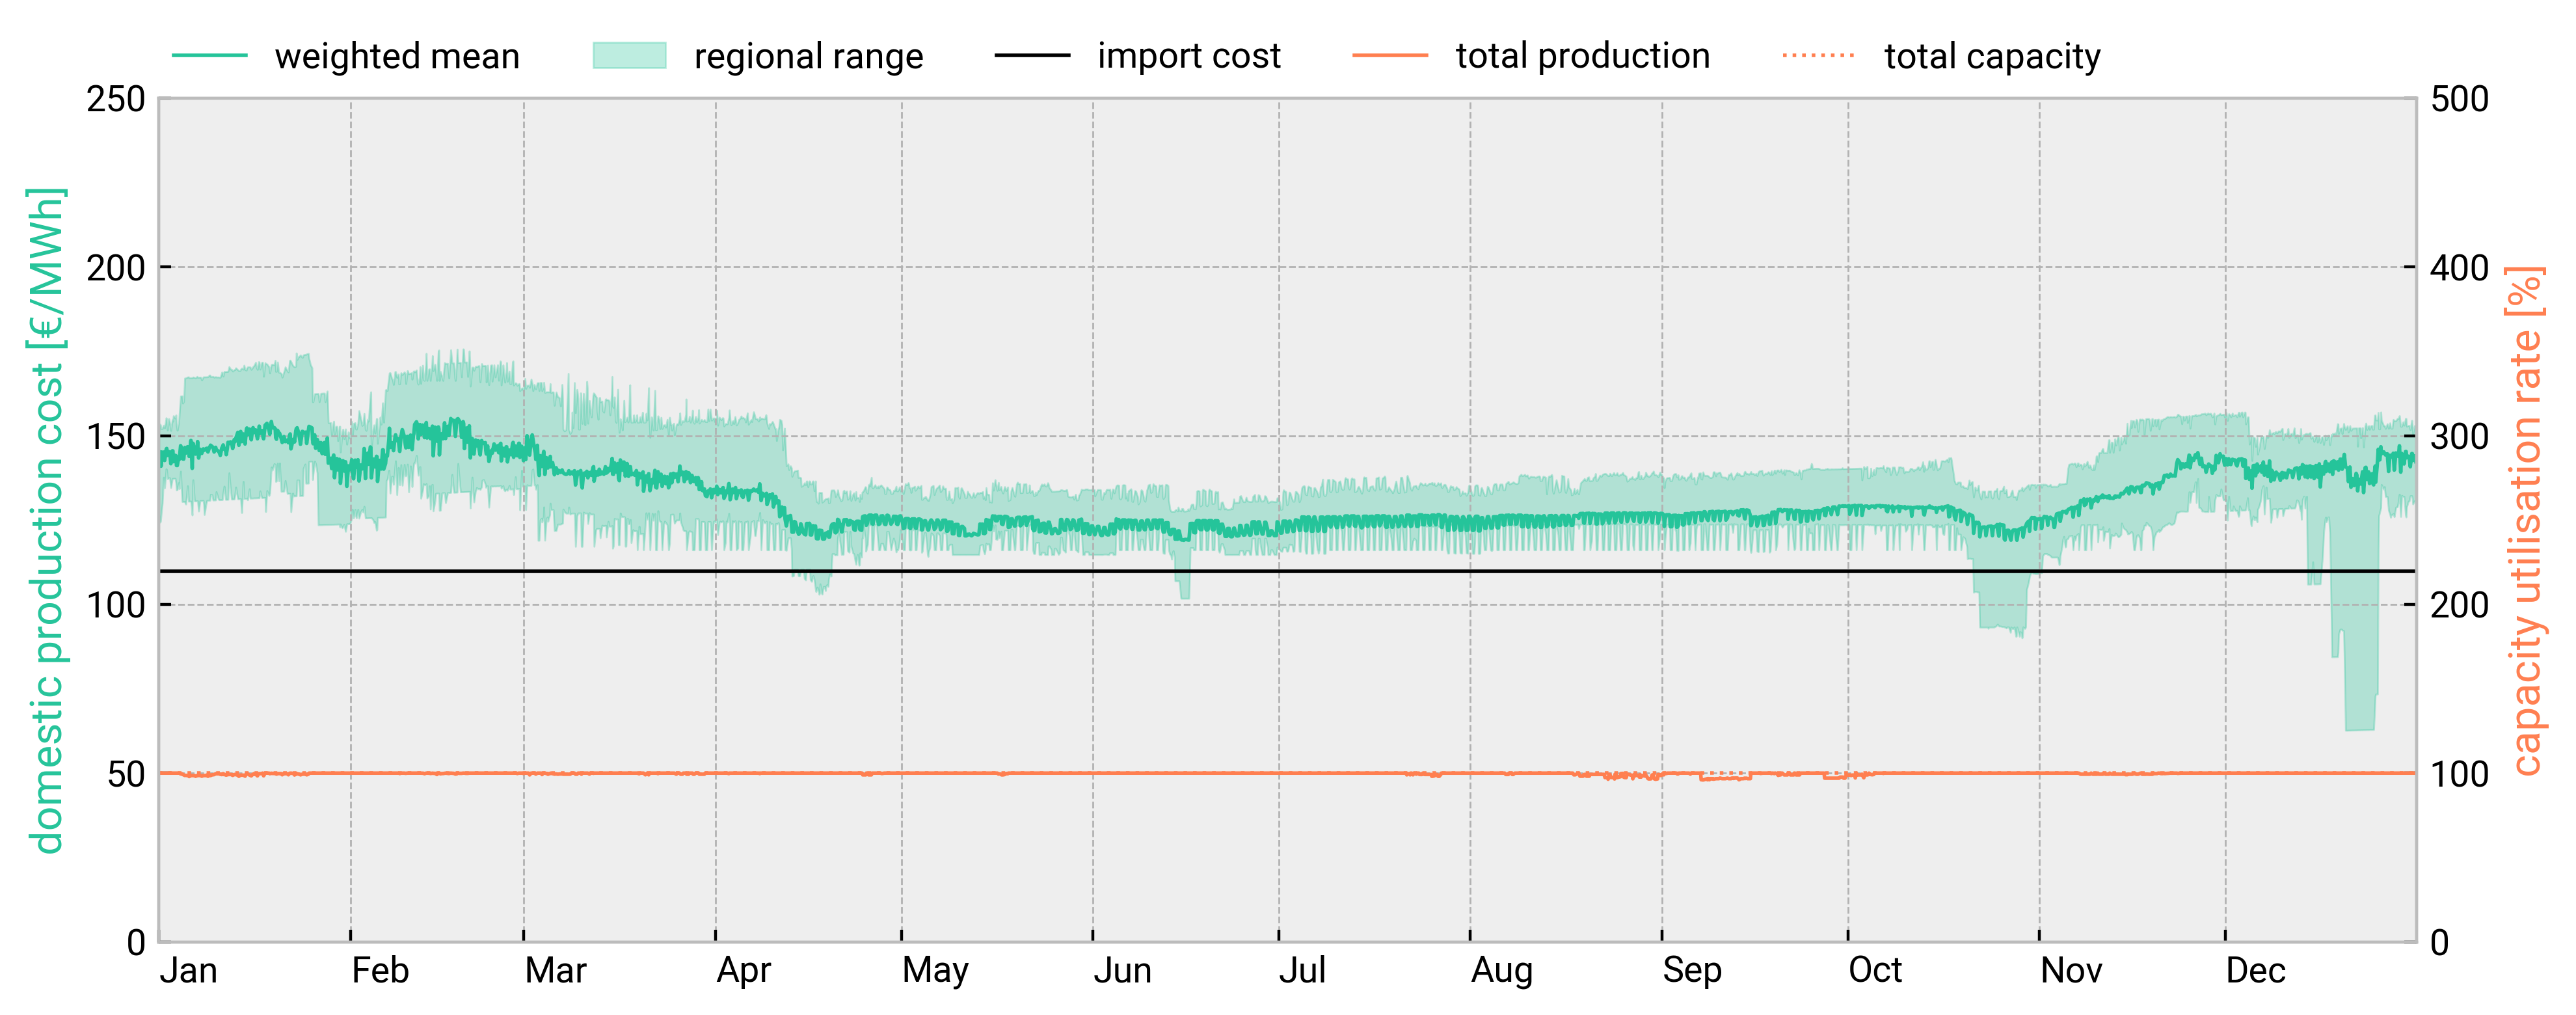

In [1664]:
mean_values = (ft_cost_t * ft_oil_output).sum(axis=1) / ft_oil_output.sum()
min_values = ft_cost_t.min(axis=1)
max_values = ft_cost_t.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

mean_values.plot(ax=ax, label="weighted mean", color=tech_colors["Fischer-Tropsch"], linewidth=1)
plt.fill_between(ft_cost_t.index, min_values, max_values, color=tech_colors["Fischer-Tropsch"], alpha=0.3, label='regional range')

ax.axhline(min_import_costs.at["Fischer-Tropsch", "min"], color="black", lw=1, label="import cost")


ax_twin = ax.twinx()

total_capacity = ft.eval("p_nom_opt * efficiency").sum()

ft_oil.sum(axis=1).div(total_capacity).mul(100).plot(ax=ax_twin, linewidth=1, color="coral", label="total production")

ax_twin.axhline(100, lw=1, label="total capacity", linestyle=":", color='coral')

ax_twin.grid(False)

ax_twin.set_ylim(0, 500)

ax_twin.set_ylabel("capacity utilisation rate [%]", color="coral")


import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for label in ax.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax.set_ylim(0, 250)

ax.set_ylabel('domestic production cost [€/MWh]', color=tech_colors["Fischer-Tropsch"])
ax.set_xlabel("")
ax.set_xlim("2013-01-01 00:00", "2013-12-31 23:00");

handles, labels = [], []
for ax in [ax, ax_twin]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single combined legend
plt.legend(handles, labels, ncol=5, loc=(0, 1.01))

plt.savefig(f"ft-t-{scenario_name}.png")

In [1665]:
# end time series

In [1666]:
ft_co2_cost = weights @ ft_co2.mul(co2_prices - co2_tax, axis=0)
ft_h2_cost = weights @ (h2_prices[ft.index] * ft_h2)
ft_oil_revenue = weights @ (ft_oil.mul(oil_prices, axis=0) - ft_co2.mul(co2_tax, axis=0))
ft_heat_revenue = weights @ (heat_prices[ft.index] * ft_heat)

In [1667]:
ft_cost = (ft_co2_cost + ft_h2_cost + ft_capex - ft_heat_revenue) / ft_oil_output

In [1668]:
ft_revenue = ft_oil_revenue / ft_oil_output

In [1669]:
ft_balance = pd.DataFrame({
    "hydrogen cost": ft_h2_cost,
    "carbon dioxide cost": ft_co2_cost,
    "investment cost": ft_capex,
    "heat revenue": -ft_heat_revenue,
    "product revenue": -ft_oil_revenue
}).div(ft_oil_output, axis=0)

ft_balance = pd.Series(
    np.average(ft_balance, weights=ft_oil_output, axis=0),
    index=ft_balance.columns
)
ft_balance

hydrogen cost           82.561058
carbon dioxide cost     42.733673
investment cost          9.267240
heat revenue            -6.473009
product revenue       -128.670530
dtype: float64

## Breakdown methanol market value

In [1670]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "methanolisation"
threshold = 1
weights = n.snapshot_weightings.generators

In [1671]:
meoh = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [1672]:
meoh_capex = meoh.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [1673]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
meoh_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
meoh_meoh = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
meoh_ac = n.links_t.p2.loc[:, sel].rename(columns=mapper)
meoh_co2 = n.links_t.p3.loc[:, sel].rename(columns=mapper)
meoh_heat = -n.links_t.p4.loc[:, sel].rename(columns=mapper)

In [1674]:
meoh_meoh_output = weights @ meoh_meoh

In [1675]:
## start time series

In [1676]:
meoh_ac_cost_t = (ac_prices[meoh.index] * meoh_ac) / meoh_meoh
meoh_co2_cost_t = meoh_co2.mul(co2_prices - co2_tax, axis=0) / meoh_meoh
meoh_h2_cost_t = (h2_prices[meoh.index] * meoh_h2) / meoh_meoh
meoh_meoh_revenue_t = (meoh_meoh.mul(oil_prices, axis=0) - meoh_co2.mul(co2_tax, axis=0)) / meoh_meoh
meoh_heat_revenue_t = (heat_prices[meoh.index] * meoh_heat) / meoh_meoh
meoh_capex_t = (meoh_capex * meoh_meoh.mul(weights, axis=0).div(meoh_meoh_output)) / meoh_meoh_output

In [1677]:
meoh_cost_t = (meoh_co2_cost_t + meoh_h2_cost_t + meoh_ac_cost_t + meoh_heat_revenue_t + meoh_capex_t)

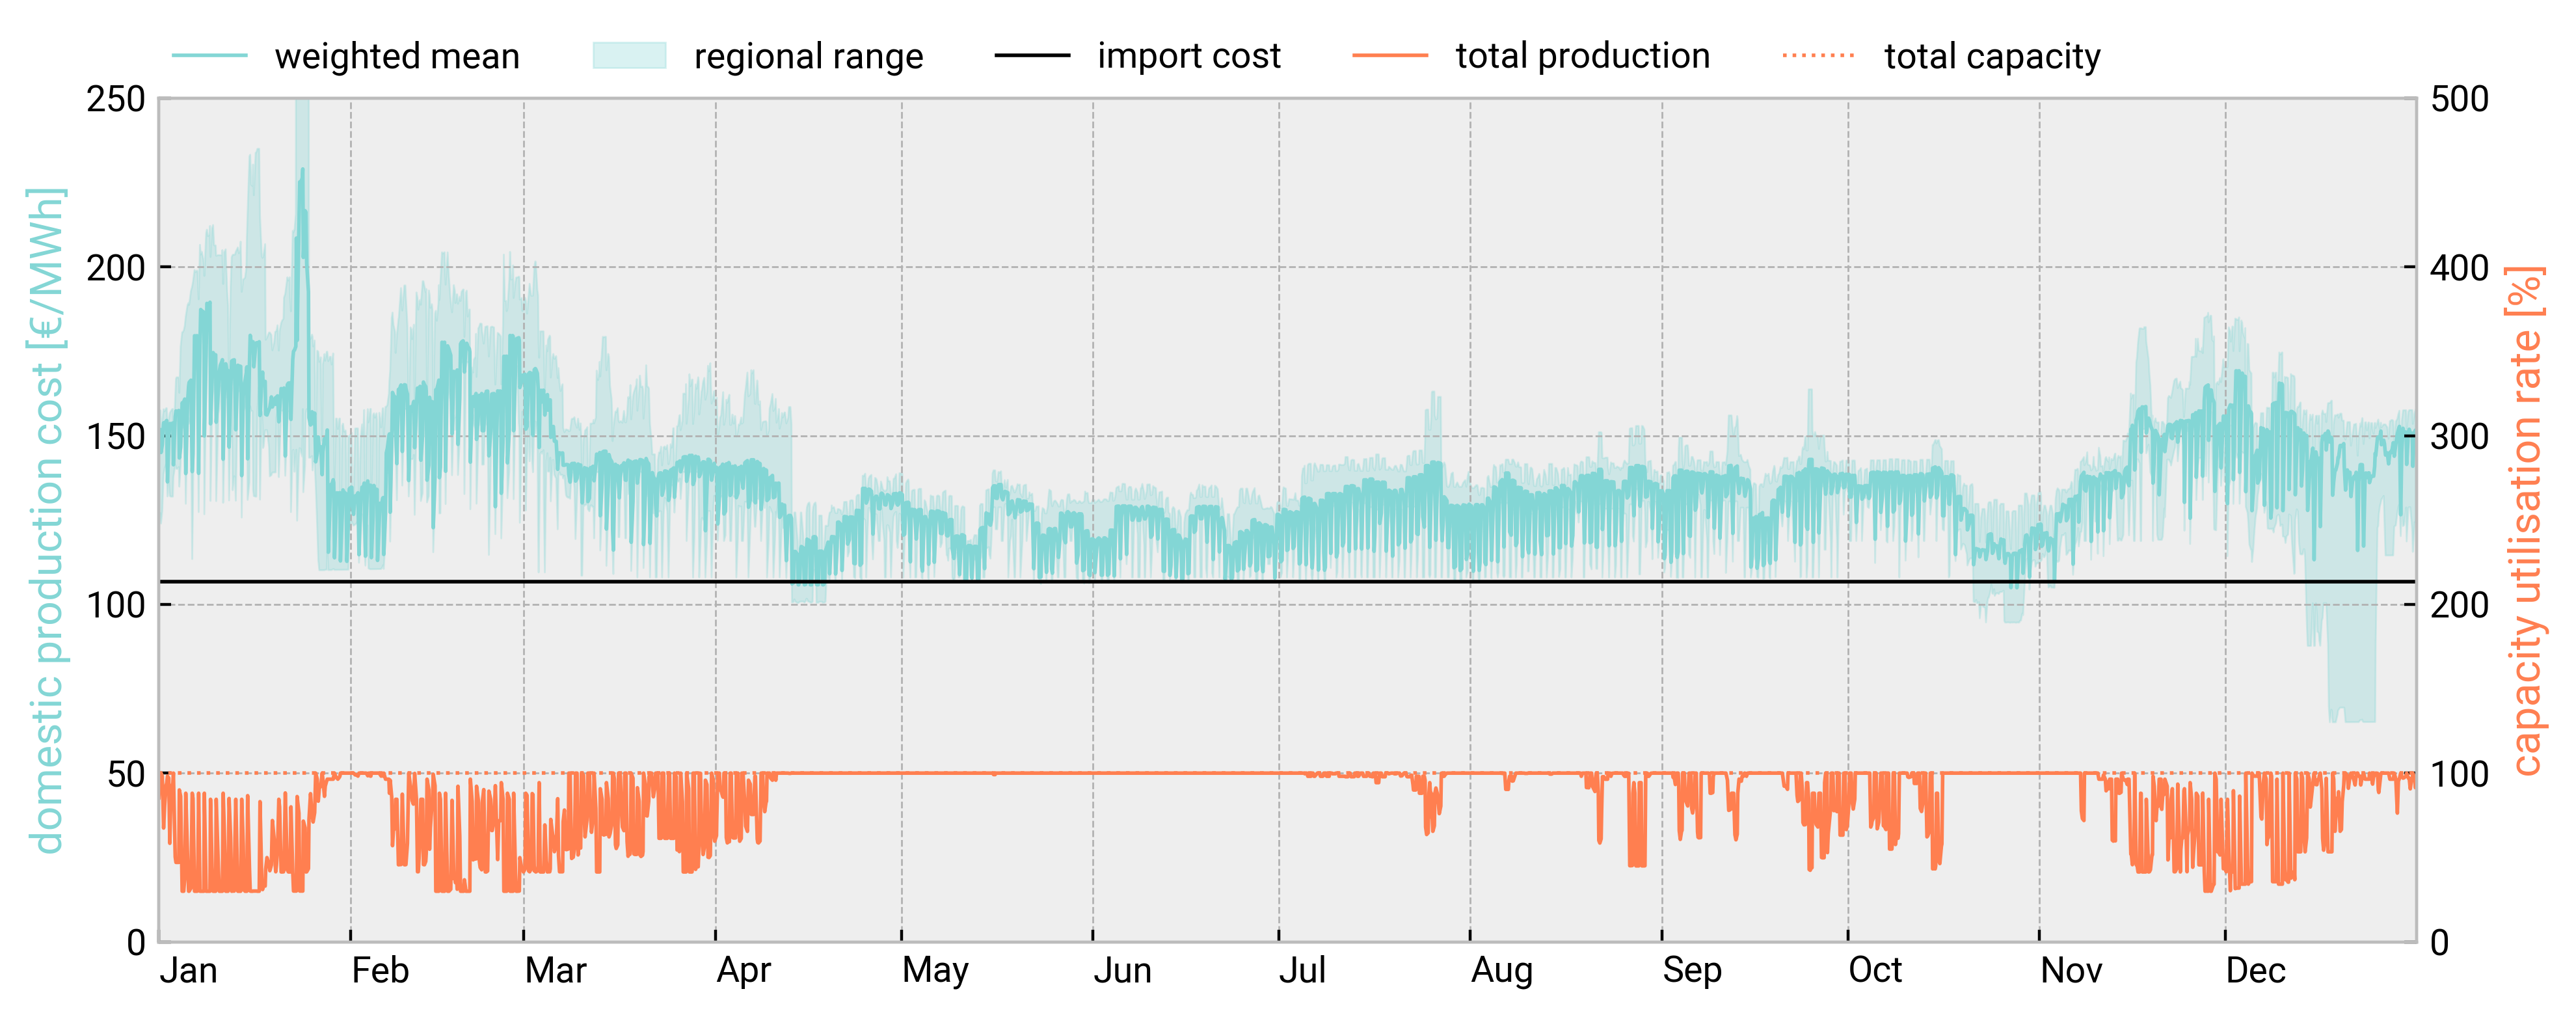

In [1678]:
mean_values = (meoh_cost_t * meoh_meoh_output).sum(axis=1) / meoh_meoh_output.sum()
min_values = meoh_cost_t.min(axis=1)
max_values = meoh_cost_t.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

mean_values.plot(ax=ax, label="weighted mean", color=tech_colors["methanolisation"], linewidth=1)
plt.fill_between(meoh_cost_t.index, min_values, max_values, color=tech_colors["methanolisation"], alpha=0.3, label='regional range')

ax.axhline(min_import_costs.at["methanol", "min"], color="black", lw=1, label="import cost")


ax_twin = ax.twinx()

total_capacity = meoh.eval("p_nom_opt * efficiency").sum()

meoh_meoh.sum(axis=1).div(total_capacity).mul(100).plot(ax=ax_twin, linewidth=1, color="coral", label="total production")

ax_twin.axhline(100, lw=1, label="total capacity", linestyle=":", color='coral')

ax_twin.grid(False)

ax_twin.set_ylim(0, 500)

ax_twin.set_ylabel("capacity utilisation rate [%]", color="coral")


import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for label in ax.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax.set_ylim(0, 250)

ax.set_ylabel('domestic production cost [€/MWh]', color=tech_colors["methanolisation"])
ax.set_xlabel("")
ax.set_xlim("2013-01-01 00:00", "2013-12-31 23:00");

handles, labels = [], []
for ax in [ax, ax_twin]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single combined legend
plt.legend(handles, labels, ncol=5, loc=(0, 1.01))


plt.savefig(f"meoh-t-{scenario_name}.png")

In [1679]:
# end time series

In [1680]:
meoh_co2_cost = weights @ meoh_co2.mul(co2_prices - co2_tax, axis=0)
meoh_h2_cost = weights @ (h2_prices[meoh.index] * meoh_h2)
meoh_ac_cost = weights @ (ac_prices[meoh.index] * meoh_ac)
meoh_meoh_revenue = weights @ (meoh_meoh.mul(meoh_prices, axis=0) - meoh_co2.mul(co2_tax, axis=0))
meoh_heat_revenue = weights @ (heat_prices[meoh.index] * meoh_heat)

In [1681]:
meoh_cost = (meoh_co2_cost + meoh_h2_cost + meoh_ac_cost + meoh_capex - meoh_heat_revenue) / meoh_meoh_output

In [1682]:
meoh_revenue = meoh_meoh_revenue / meoh_meoh_output

In [1683]:
meoh_balance = pd.DataFrame({
    "electricity cost": meoh_ac_cost,
    "hydrogen cost": meoh_h2_cost,
    "carbon dioxide cost": meoh_co2_cost,
    "investment cost": meoh_capex,
    "heat revenue": -meoh_heat_revenue,
    "product revenue": -meoh_meoh_revenue
}).div(meoh_meoh_output, axis=0)

try:
    meoh_balance = pd.Series(
        np.average(meoh_balance, weights=meoh_meoh_output, axis=0),
        index=meoh_balance.columns
    )
except:
    meoh_balance = pd.Series(index=ft_balance.index)
meoh_balance

electricity cost        15.076478
hydrogen cost           73.485113
carbon dioxide cost     41.221124
investment cost         10.715122
heat revenue            -1.951291
product revenue       -139.216097
dtype: float64

## Breakdown methane market value

In [1684]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Sabatier"
threshold = 1
weights = n.snapshot_weightings.generators

In [1685]:
sab = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [1686]:
sab_capex = sab.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [1687]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
sab_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
sab_gas = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
sab_co2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
sab_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [1688]:
sab_gas_output = weights @ sab_gas

In [1689]:
## start time series

In [1690]:
sab_co2_cost_t = sab_co2.mul(co2_prices - co2_tax, axis=0) / sab_gas
sab_h2_cost_t = (h2_prices[sab.index] * sab_h2) / sab_gas
sab_gas_revenue_t = ((gas_prices[sab.index] * sab_gas) - sab_co2.mul(co2_tax, axis=0)) / sab_gas
sab_heat_revenue_t = (heat_prices[sab.index] * sab_heat) / sab_gas
sab_capex_t = (sab_capex * sab_gas.mul(weights, axis=0).div(sab_gas_output)) / sab_gas_output

In [1691]:
sab_cost_t = (sab_co2_cost_t + sab_h2_cost_t + sab_heat_revenue_t + sab_capex_t)

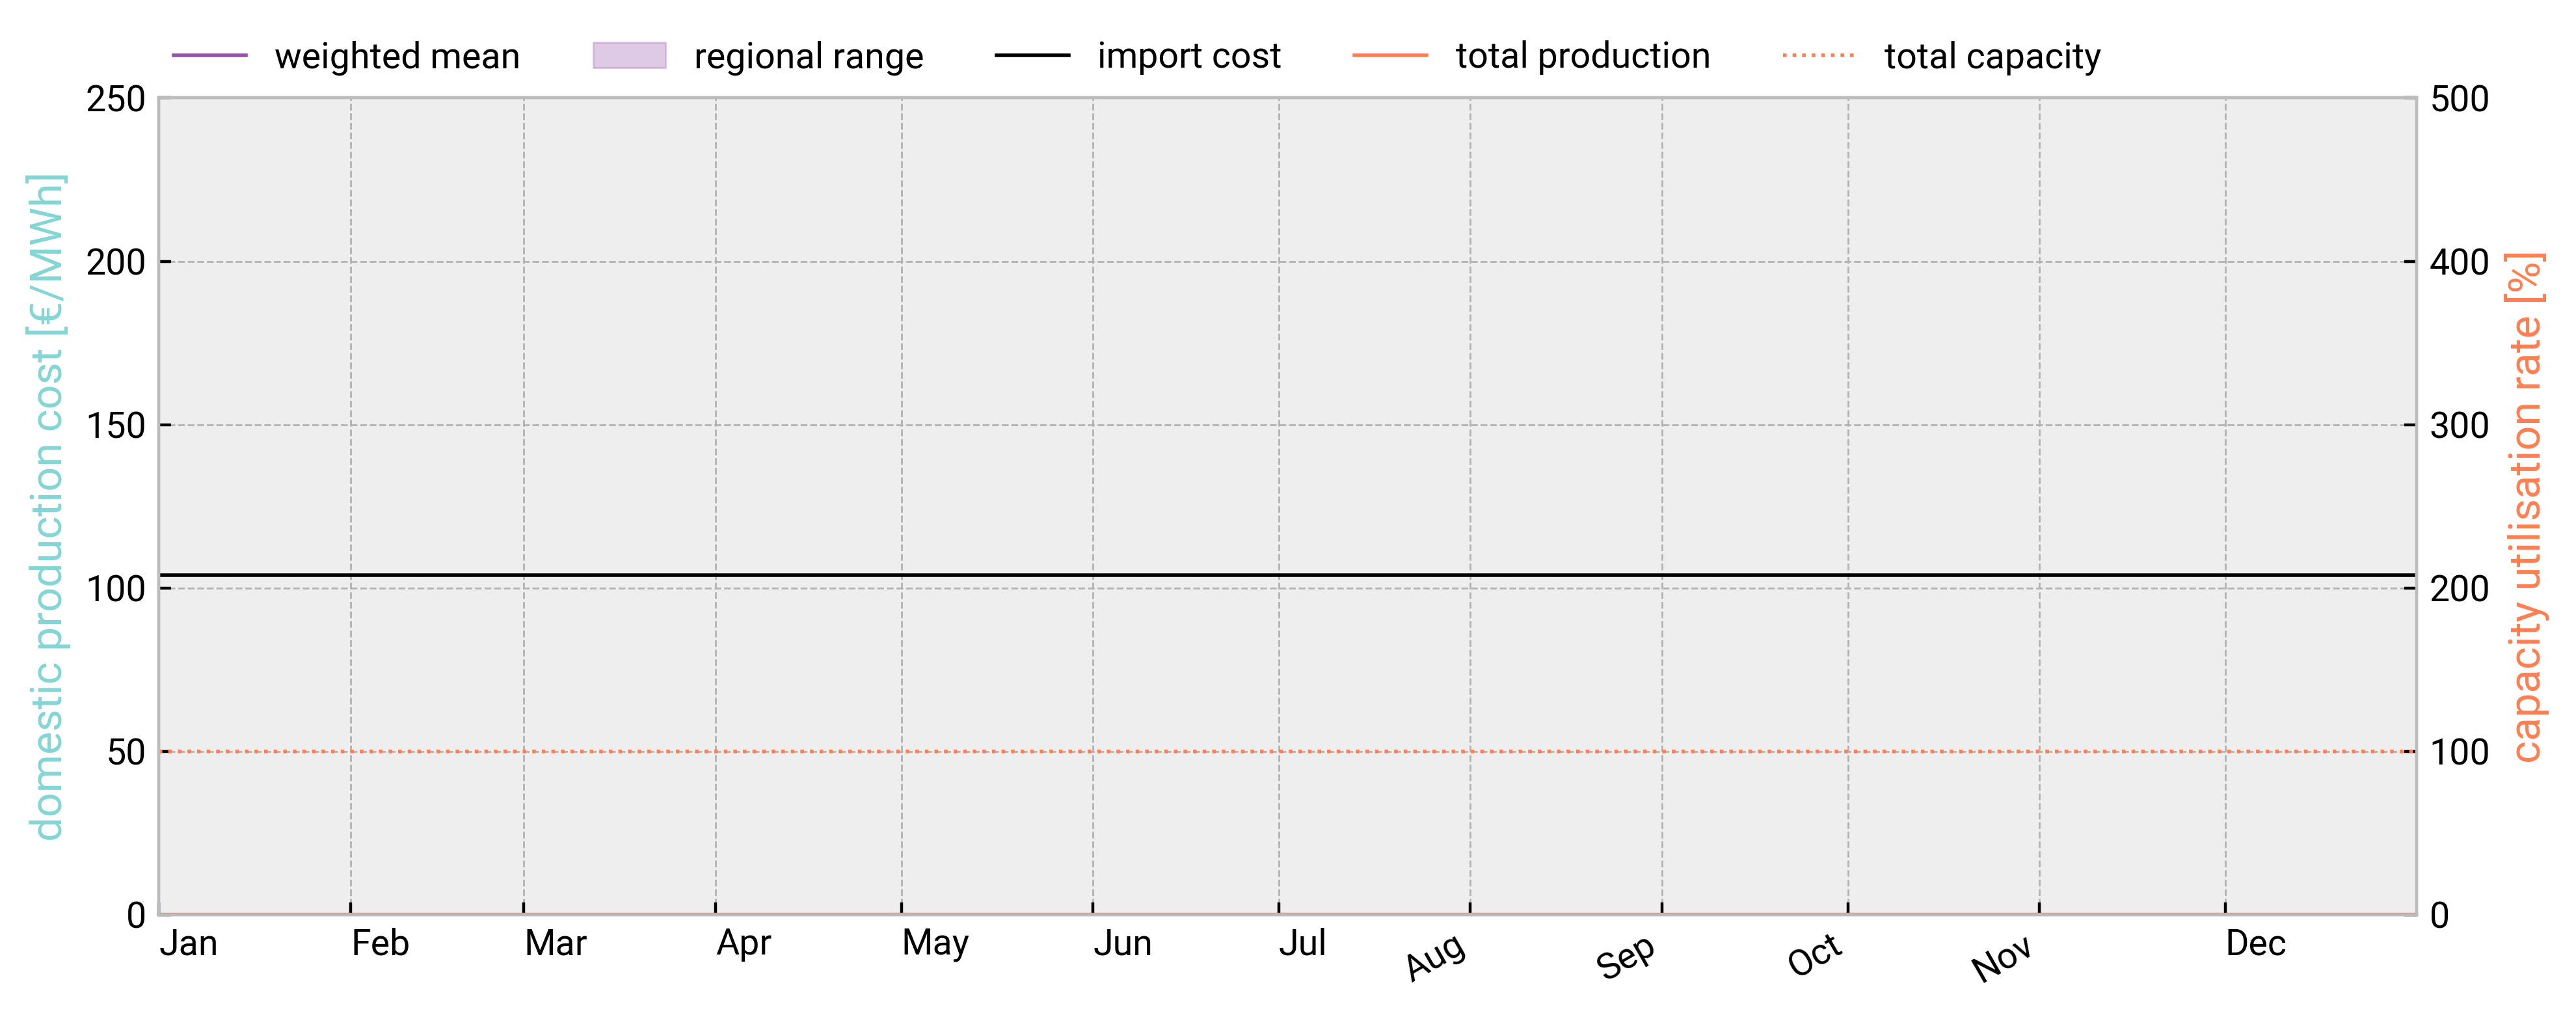

In [1692]:
mean_values = (sab_cost_t * sab_gas_output).sum(axis=1) / sab_gas_output.sum()
min_values = sab_cost_t.min(axis=1)
max_values = sab_cost_t.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

mean_values.plot(ax=ax, label="weighted mean", color=tech_colors["Sabatier"], linewidth=1)
plt.fill_between(sab_cost_t.index, min_values, max_values, color=tech_colors["Sabatier"], alpha=0.3, label='regional range')

ax.axhline(min_import_costs.at["methane", "min"], color="black", lw=1, label="import cost")


ax_twin = ax.twinx()

total_capacity = meoh.eval("p_nom_opt * efficiency").sum()

sab_gas.sum(axis=1).div(total_capacity).mul(100).plot(ax=ax_twin, linewidth=1, color="coral", label="total production")

ax_twin.axhline(100, lw=1, label="total capacity", linestyle=":", color='coral')

ax_twin.grid(False)

ax_twin.set_ylim(0, 500)

ax_twin.set_ylabel("capacity utilisation rate [%]", color="coral")


import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for label in ax.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax.set_ylim(0, 250)

ax.set_ylabel('domestic production cost [€/MWh]', color=tech_colors["methanolisation"])
ax.set_xlabel("")
ax.set_xlim("2013-01-01 00:00", "2013-12-31 23:00");

handles, labels = [], []
for ax in [ax, ax_twin]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single combined legend
plt.legend(handles, labels, ncol=5, loc=(0, 1.01))


plt.savefig(f"sab-t-{scenario_name}.png")

In [1693]:
# end time series

In [1694]:
sab_co2_cost = weights @ sab_co2.mul(co2_prices - co2_tax, axis=0)
sab_h2_cost = weights @ (h2_prices[sab.index] * sab_h2)
sab_gas_revenue = weights @ ((gas_prices[sab.index] * sab_gas) - sab_co2.mul(co2_tax, axis=0))
sab_heat_revenue = weights @ (heat_prices[sab.index] * sab_heat)

In [1695]:
sab_cost = (sab_co2_cost + sab_h2_cost + sab_capex - sab_heat_revenue) / sab_gas_output

In [1696]:
sab_revenue = sab_gas_revenue / sab_gas_output

In [1697]:
sab_balance = pd.DataFrame({
    "hydrogen cost": sab_h2_cost,
    "carbon dioxide cost": sab_co2_cost,
    "investment cost": sab_capex,
    "heat revenue": -sab_heat_revenue,
    "product revenue": -sab_gas_revenue
}).div(sab_gas_output, axis=0)

try:
    sab_balance = pd.Series(
        np.average(sab_balance, weights=sab_gas_output, axis=0),
        index=sab_balance.columns
    )
except:
    sab_balance = pd.Series(index=ft_balance.index)
sab_balance

hydrogen cost         NaN
carbon dioxide cost   NaN
investment cost       NaN
heat revenue          NaN
product revenue       NaN
dtype: float64

## Breakdown steel market value

In [1698]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "DRI + Electric arc"
threshold = 1
weights = n.snapshot_weightings.generators

In [1699]:
drieaf = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [1700]:
drieaf_capex = drieaf.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [1701]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
drieaf_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
drieaf_steel = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
drieaf_h2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)

In [1702]:
drieaf_steel_output = weights @ drieaf_steel

In [1703]:
drieaf_h2_cost = weights @ (h2_prices[drieaf.index] * drieaf_h2)
drieaf_ac_cost = weights @ (ac_prices[drieaf.index] * drieaf_ac)
drieaf_ore_cost = weights @ (drieaf.marginal_cost * drieaf_ac) # since AC is bus0
drieaf_steel_revenue =  weights @ drieaf_steel.mul(steel_prices, axis=0)

In [1704]:
drieaf_cost = (drieaf_h2_cost + drieaf_ac_cost + drieaf_ore_cost + drieaf_capex) / drieaf_steel_output

In [1705]:
drieaf_revenue = drieaf_steel_revenue / drieaf_steel_output

In [1706]:
drieaf_balance = pd.DataFrame({
    "electricity cost": drieaf_ac_cost,
    "hydrogen cost": drieaf_h2_cost,
    "iron ore": drieaf_ore_cost,
    "investment cost": drieaf_capex,
    "product revenue": -drieaf_steel_revenue
}).div(drieaf_steel_output, axis=0)

try:
    drieaf_balance = pd.Series(
        np.average(drieaf_balance, weights=drieaf_steel_output, axis=0),
        index=drieaf_balance.columns
    )
except:
    drieaf_balance = pd.Series(index=["electricity cost", "hydrogen cost", "iron ore", "investment cost", "product revenue"])
drieaf_balance

electricity cost     86.812965
hydrogen cost       141.379927
iron ore            164.941279
investment cost     167.204365
product revenue    -570.596349
dtype: float64

In [1707]:
import seaborn as sns
pal = sns.color_palette("colorblind", 10)
pal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [1708]:
colors = {
    "heat revenue": '#d55e00',
    "investment cost":  '#de8f05',
    "electricity cost": '#0173b2',
    "hydrogen cost": "#029e73",
    "carbon dioxide cost": "#cc78bc",
    "iron ore": "#ca9161",
}

In [1709]:
composition

hydrogen    ammonia  methane  Fischer-Tropsch  \
heat revenue         -4.788700  -5.584088      NaN        -8.014859   
investment cost      21.059422  11.788802      NaN         9.685523   
electricity cost     57.144522   7.764832      NaN              NaN   
hydrogen cost              NaN  84.092208      NaN       102.834483   
carbon dioxide cost        NaN        NaN      NaN        37.048897   
iron ore                   NaN        NaN      NaN              NaN   

                      methanol       steel  
heat revenue         -1.113130         NaN  
investment cost      12.825711  169.157482  
electricity cost     15.019770   90.963199  
hydrogen cost        85.492973  165.680172  
carbon dioxide cost  35.737559         NaN  
iron ore                   NaN  164.941423

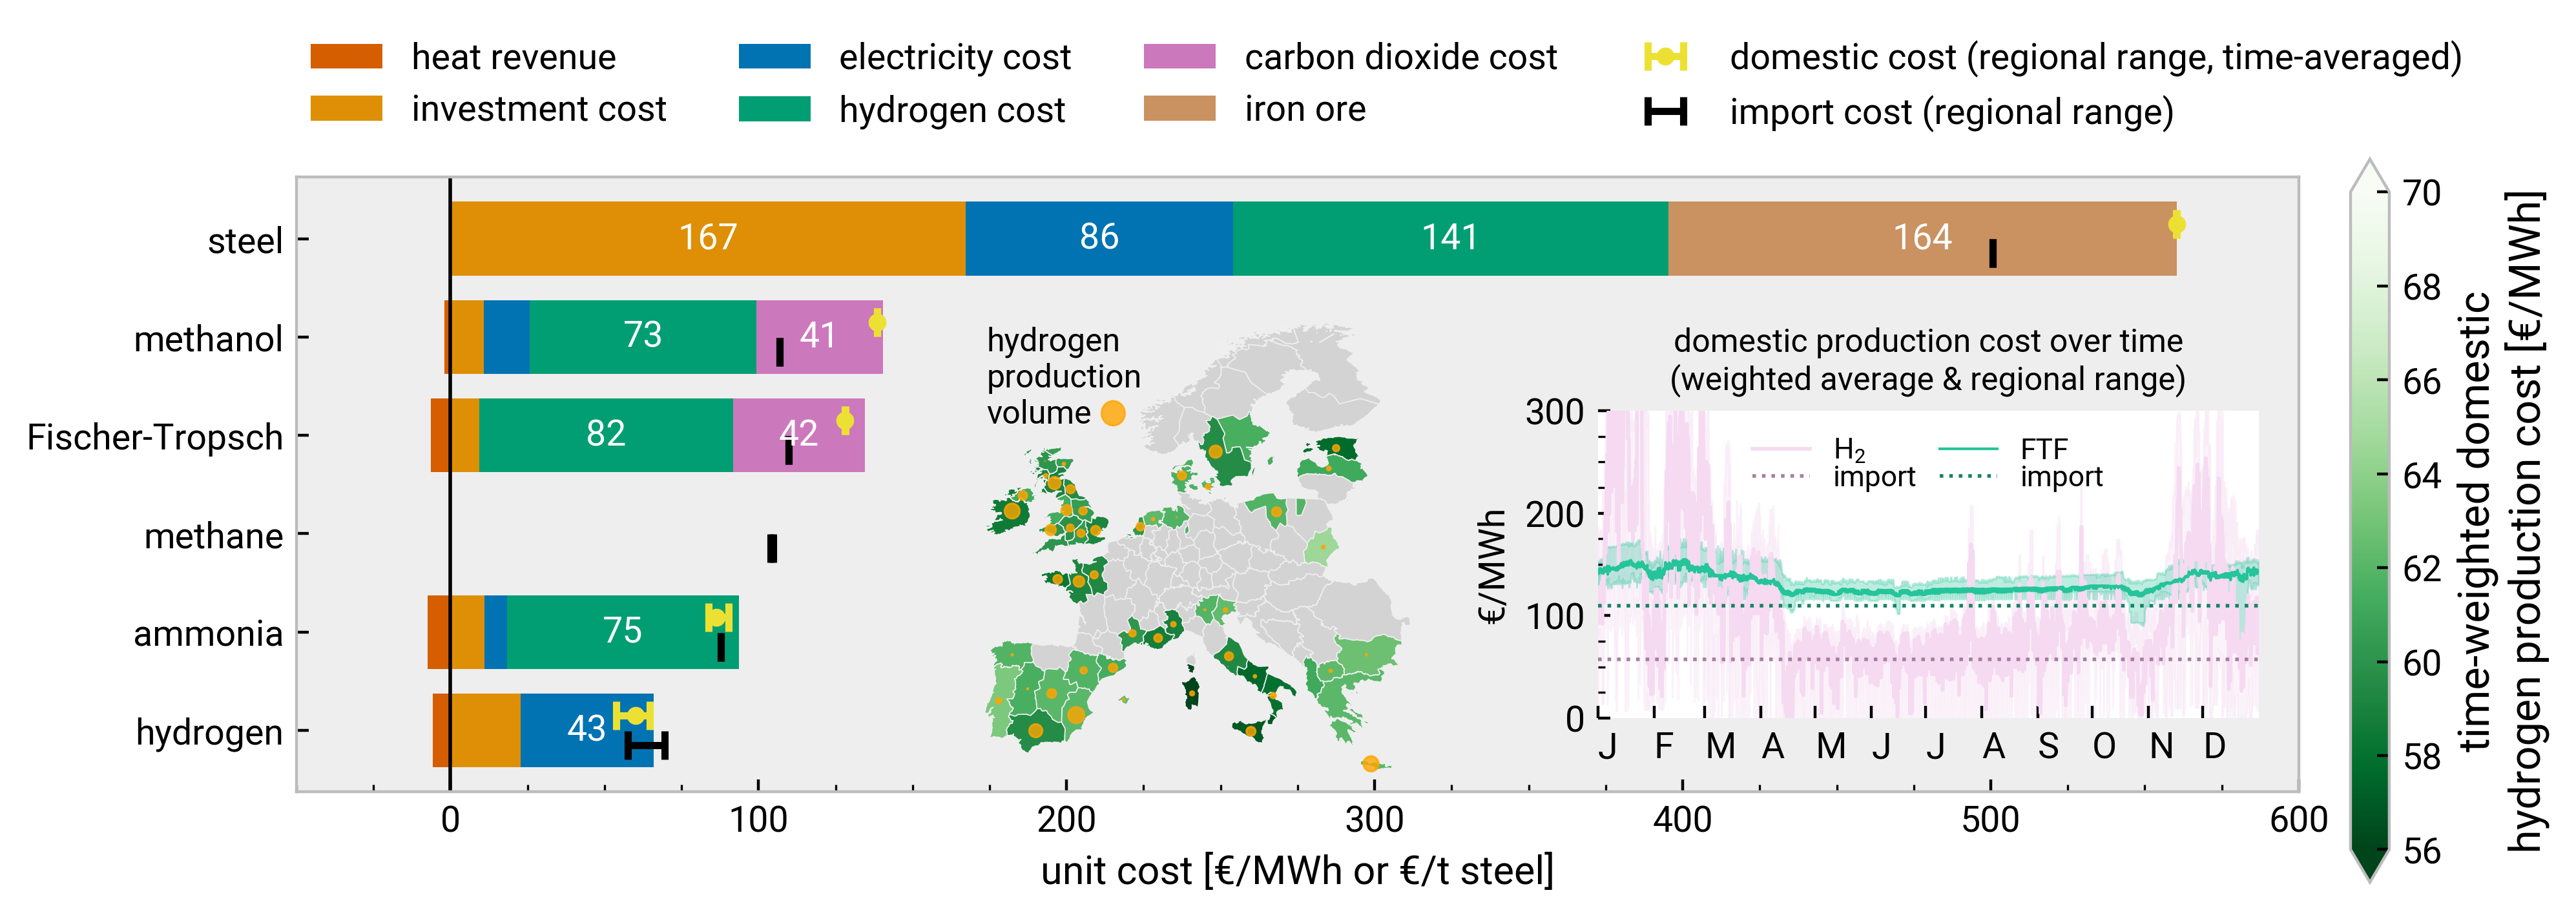

In [1710]:
fig, ax = plt.subplots(figsize=(10, 3.5))

fig.set_tight_layout(False)

composition = pd.concat({
    "hydrogen": electrolysers_balance,
    "ammonia": haberbosch_balance,
    "methane": sab_balance,
    "Fischer-Tropsch": ft_balance,
    "methanol": meoh_balance,
    "steel": drieaf_balance,
}, axis=1).drop("product revenue")

composition = composition.loc[colors.keys()]

costs = composition.sum()
costs = costs.where(costs > 0)

barh = composition.T.plot.barh(ax=ax, stacked=True, width=0.75, color=colors)

for container in ax.containers:
    ax.bar_label(
        container,
        label_type="center",
        color="white",
        fmt=lambda x: x.astype(int) if x > 25 else "",
    )

errors = pd.concat({
    "hydrogen": electrolysers_cost,
    "ammonia": haberbosch_cost,
    "methane": sab_cost,
    "Fischer-Tropsch": ft_cost,
    "methanol": meoh_cost,
    "steel": drieaf_cost,
}, axis=1).describe().loc[["min", "max"]].sub(costs).T.abs()

from matplotlib.transforms import Affine2D
trans1 = Affine2D().translate(0.0, 0.15) + ax.transData
trans2 = Affine2D().translate(0.0, -0.15) + ax.transData

ax.errorbar(
    costs,
    composition.columns,
    xerr=errors.T.values,
    fmt='.',
    capsize=4,
    elinewidth=2,
    capthick=2,
    color='#ece133',
    transform=trans1,
    markersize=8,
    label="domestic cost (regional range, time-averaged)"
)

imports = min_import_costs.reindex_like(errors)

ax.errorbar(
    imports.min(axis=1),
    composition.columns,
    xerr=(imports.T - imports.min(axis=1)).values,
    fmt='None',
    capsize=4,
    elinewidth=2,
    capthick=2,
    color='k',
    transform=trans2,
    markersize=8,
    label="import cost (regional range)"
)

ax.axvline(0, color='k', lw=1)

plt.xlim(-50, 600)
plt.grid(axis="y")
plt.xlabel("unit cost [€/MWh or €/t steel]", fontsize=11)

plt.legend(ncol=4, loc=(0,1.05))

plt.xticks(range(-50, 600, 25), minor=True);

ax_inset = ax.inset_axes([0.05, 0, 0.8, 0.8])

regions_fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/resources/20231025-zecm/regions_onshore_elec_s_110.geojson"
crs = ccrs.EqualEarth()
regions = gpd.read_file(regions_fn).set_index("name").to_crs(crs.proj4_init)

left, bottom, width, height = [0.92, 0.1, 0.015, 0.8]
ax_cbar = fig.add_axes([left, bottom, width, height])
ax_cbar.grid(False)

regions_plot = regions.plot(
    ax=ax_inset,
    cmap="Greens_r",
    column=electrolysers_cost.reindex(regions.index),
    missing_kwds=dict(color="lightgrey", label="no electrolysers"),
    linewidth=.3,
    edgecolor="#efefef",
    cax=ax_cbar,
    vmin=56,
    vmax=70,
    legend=True,
    legend_kwds={
        "label": "time-weighted domestic\nhydrogen production cost [€/MWh]",
        "shrink": 0.9,
        "extend": "both",
        "pad": 0,
        "aspect": 35,
    },
)

regions.representative_point().plot(
    ax=ax_inset,
    markersize=electrolysers_h2_output.reindex(regions.index) / 3e6,
    color='orange',
    alpha=0.8,
)
circle = Circle((0.32,0.77), 0.025, color='orange', alpha=0.8, transform=ax_inset.transAxes)
ax_inset.add_patch(circle)

ax_inset.text(0.05, 0.75, "hydrogen\nproduction\nvolume", transform=ax_inset.transAxes, fontsize=9)

ax_inset.axis('off')
ax_inset.set_facecolor('none')

ax_inset2 = ax.inset_axes([0.65, 0.12, 0.33, 0.5])

mean_values = (electrolysers_cost_t * electrolysers_h2_output).sum(axis=1) / electrolysers_h2_output.sum()
min_values = electrolysers_cost_t.min(axis=1)
max_values = electrolysers_cost_t.max(axis=1)

mean_values.plot(ax=ax_inset2, label=r"H$_2$", color="#f5daf1", linewidth=1)
ax_inset2.fill_between(electrolysers_cost_t.index, min_values, max_values, color="#f5daf1", alpha=0.3)

ax_inset2.axhline(min_import_costs.at["hydrogen", "min"], color="#a67ea0", lw=1, linestyle=":", label="import")

mean_values = (ft_cost_t * ft_oil_output).sum(axis=1) / ft_oil_output.sum()
min_values = ft_cost_t.min(axis=1)
max_values = ft_cost_t.max(axis=1)

mean_values.plot(ax=ax_inset2, label="FTF", color=tech_colors["Fischer-Tropsch"], linewidth=0.75)
ax_inset2.fill_between(ft_cost_t.index, min_values, max_values, color=tech_colors["Fischer-Tropsch"], alpha=0.3)

ax_inset2.axhline(min_import_costs.at["Fischer-Tropsch", "min"], color="#178266", lw=1, linestyle=":", label="import")

ax_inset2.legend(fontsize=8, ncol=2, labelspacing=0, columnspacing=0.8)

import matplotlib.dates as mdates
import matplotlib.ticker as ticker
class FirstLetterOfMonthFormatter(ticker.Formatter):
    def __init__(self):
        super().__init__()

    def __call__(self, x, pos=None):
        dt = mdates.num2date(x)
        return dt.strftime('%b')[0]

ax_inset2.xaxis.set_major_formatter(FirstLetterOfMonthFormatter())
for label in ax_inset2.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax_inset2.set_ylim(0, 300)

ax_inset2.set_title("domestic production cost over time\n(weighted average & regional range)", fontsize=9)
ax_inset2.set_ylabel('€/MWh', fontsize=10)
ax_inset2.set_xlabel("")
ax_inset2.set_xlim("2013-01-01 00:00", "2013-12-31 23:00")
ax_inset2.grid(False)
ax_inset2.set_facecolor('white')
ax_inset2.set_yticks(range(0, 300, 25), minor=True)
for i in ["top", "right", "left", "bottom"]:
    ax_inset2.spines[i].set_visible(False)



handles, labels = ax_inset2.get_legend_handles_labels()

ax.grid(False)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/market-values-{scenario_name}{ext}", bbox_inches='tight')

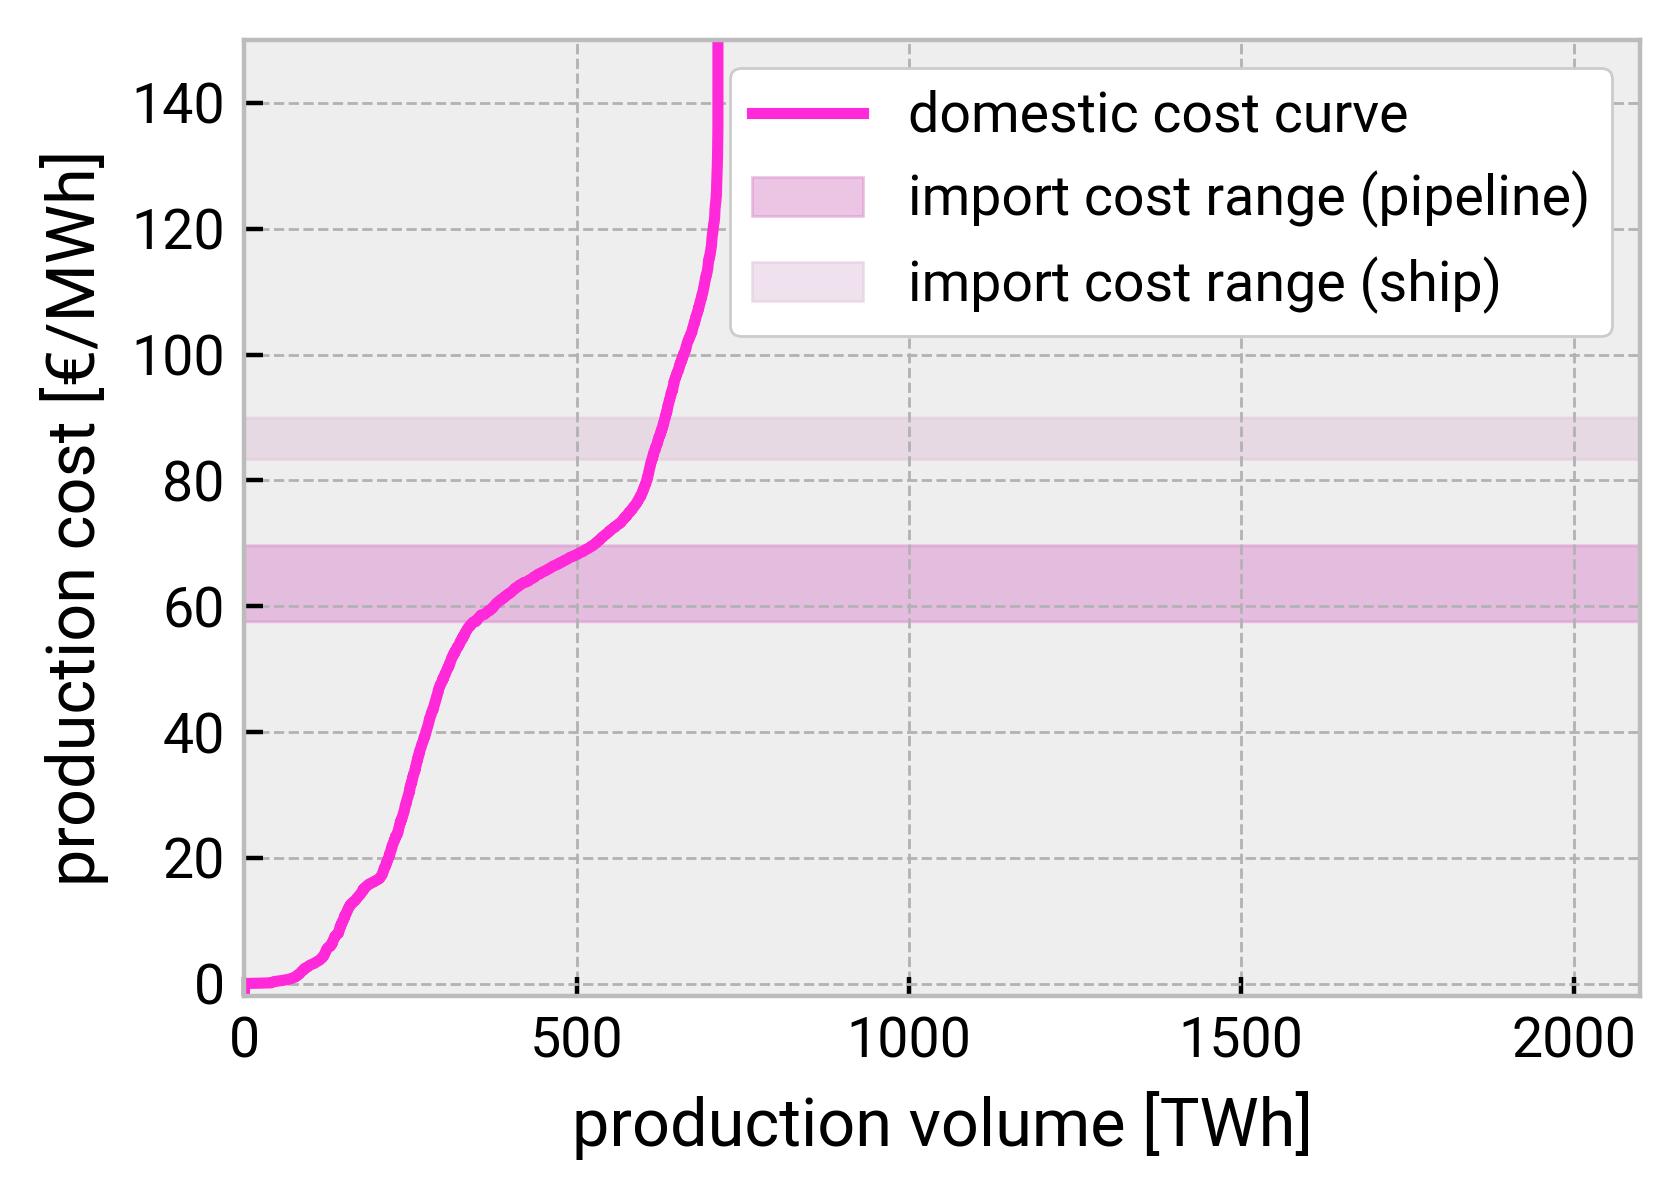

In [1711]:
csc = pd.concat({
    "mv": electrolysers_cost_t.stack(),
    "vol": electrolysers_h2.mul(n.snapshot_weightings.generators, axis=0).stack().div(1e6), # TWh
}, axis=1).sort_values(by='mv').reset_index(drop=True)

csc['cum_vol'] = csc['vol'].cumsum()
fig, ax = plt.subplots(figsize=(4.3,3.1))
plt.plot(
    csc['cum_vol'],
    csc['mv'],
    marker='none',
    linestyle='-',
    color=tech_colors["H2 Electrolysis"],
    label="domestic cost curve"
)
plt.ylabel('production cost [€/MWh]')
plt.xlabel('production volume [TWh]')
ax.set_xlim(0, 2100)
ax.set_ylim(-2, 150)
ax.fill_between(
    csc["mv"]*2,
    min_import_costs.at["hydrogen", "min"],
    min_import_costs.at["hydrogen", "max"],
    color=tech_colors["import pipeline-h2"],
    alpha=0.5,
    label="import cost range (pipeline)"
)
ax.fill_between(
    csc["mv"]*2,
    min_import_costs.at["hydrogen (ship)", "min"],
    min_import_costs.at["hydrogen (ship)", "max"],
    color=tech_colors["import shipping-lh2"],
    alpha=0.5,
    label="import cost range (ship)"
)

plt.legend(frameon=True, facecolor='white', framealpha=1)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/csc-h2-{scenario_name}{ext}", bbox_inches='tight')

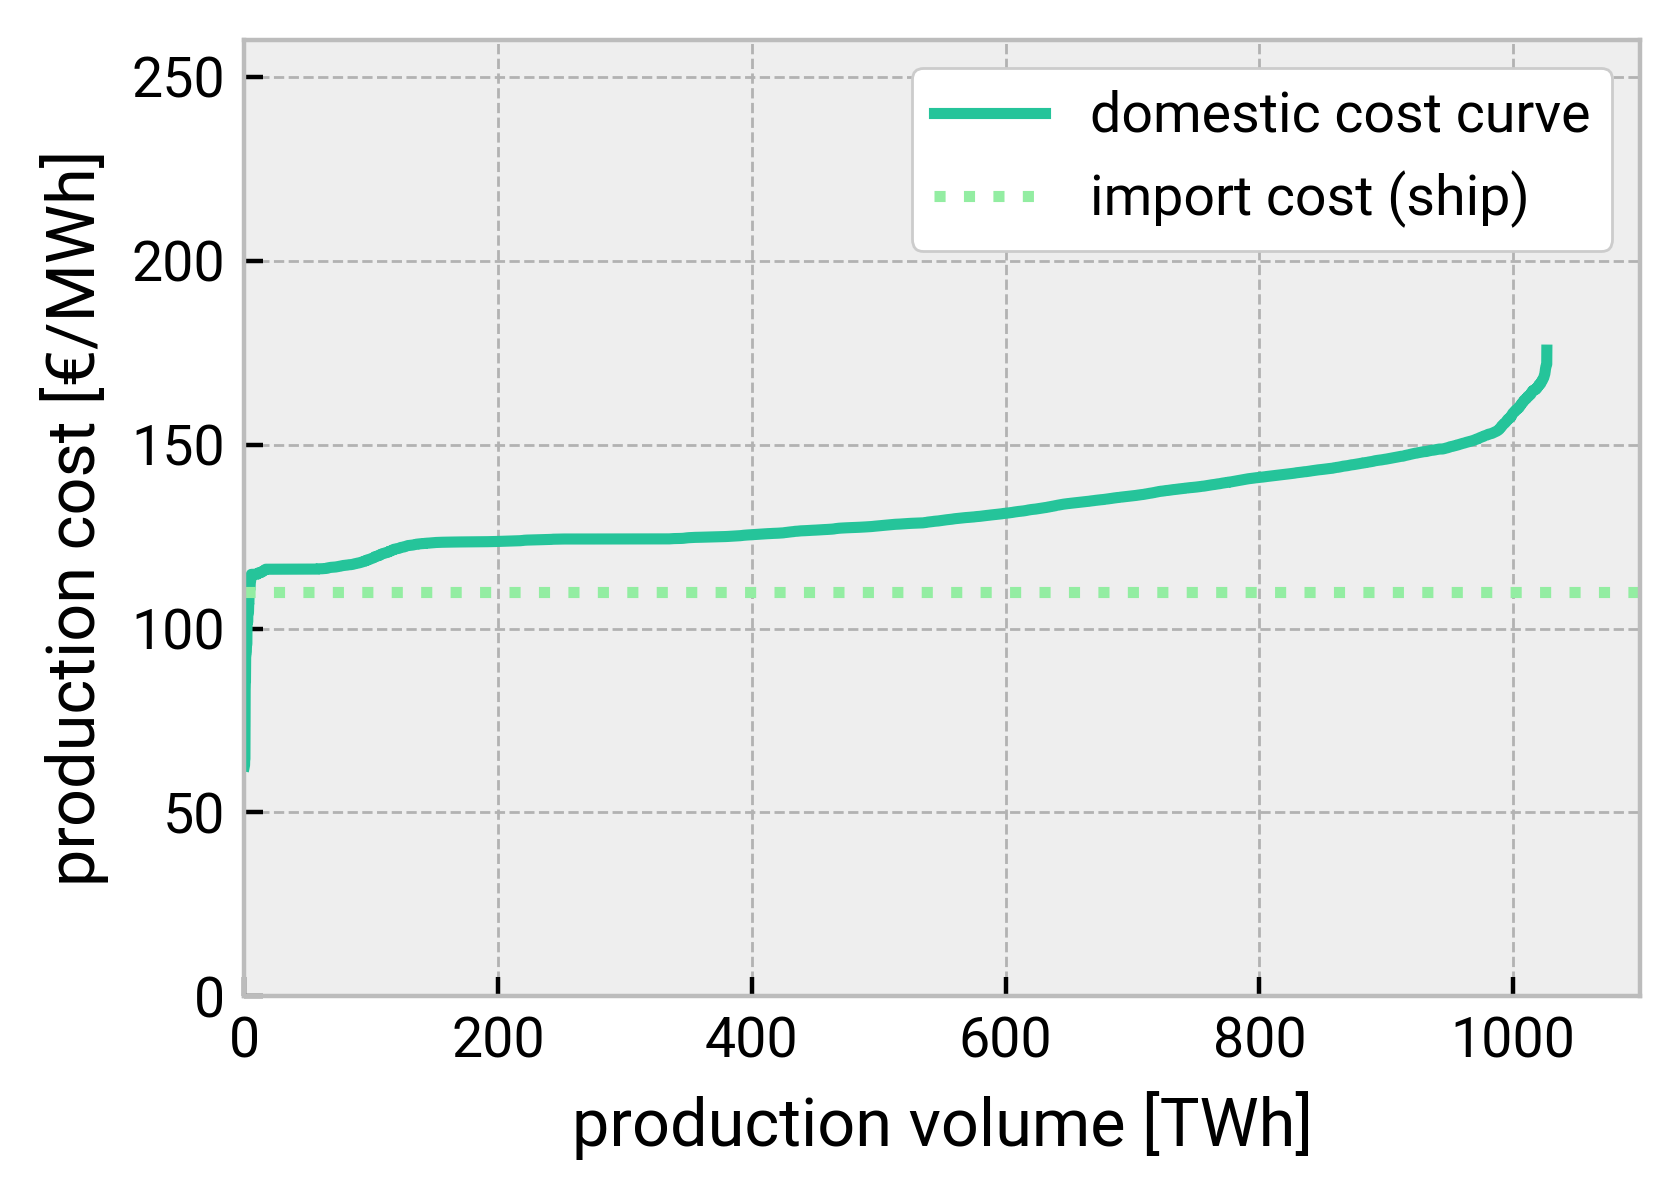

In [1712]:
csc = pd.concat({
    "mv": ft_cost_t.stack(),
    "vol": ft_oil.mul(n.snapshot_weightings.generators, axis=0).stack().div(1e6), # TWh
}, axis=1).sort_values(by='mv').reset_index(drop=True)

csc['cum_vol'] = csc['vol'].cumsum()
fig, ax = plt.subplots(figsize=(4.3,3.1))
plt.plot(
    csc['cum_vol'],
    csc['mv'],
    marker='none',
    linestyle='-',
    color=tech_colors["Fischer-Tropsch"],
    label="domestic cost curve"
)
plt.ylabel('production cost [€/MWh]')
plt.xlabel('production volume [TWh]')
ax.set_xlim(0, 1100)
ax.set_ylim(0, 260)
ax.axhline(
    min_import_costs.at["Fischer-Tropsch", "min"],
    color=tech_colors["import shipping-ftfuel"],
    label="import cost (ship)",
    linestyle=":",
)


plt.legend(frameon=True, facecolor='white', framealpha=1)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/csc-ftf-{scenario_name}{ext}", bbox_inches='tight')

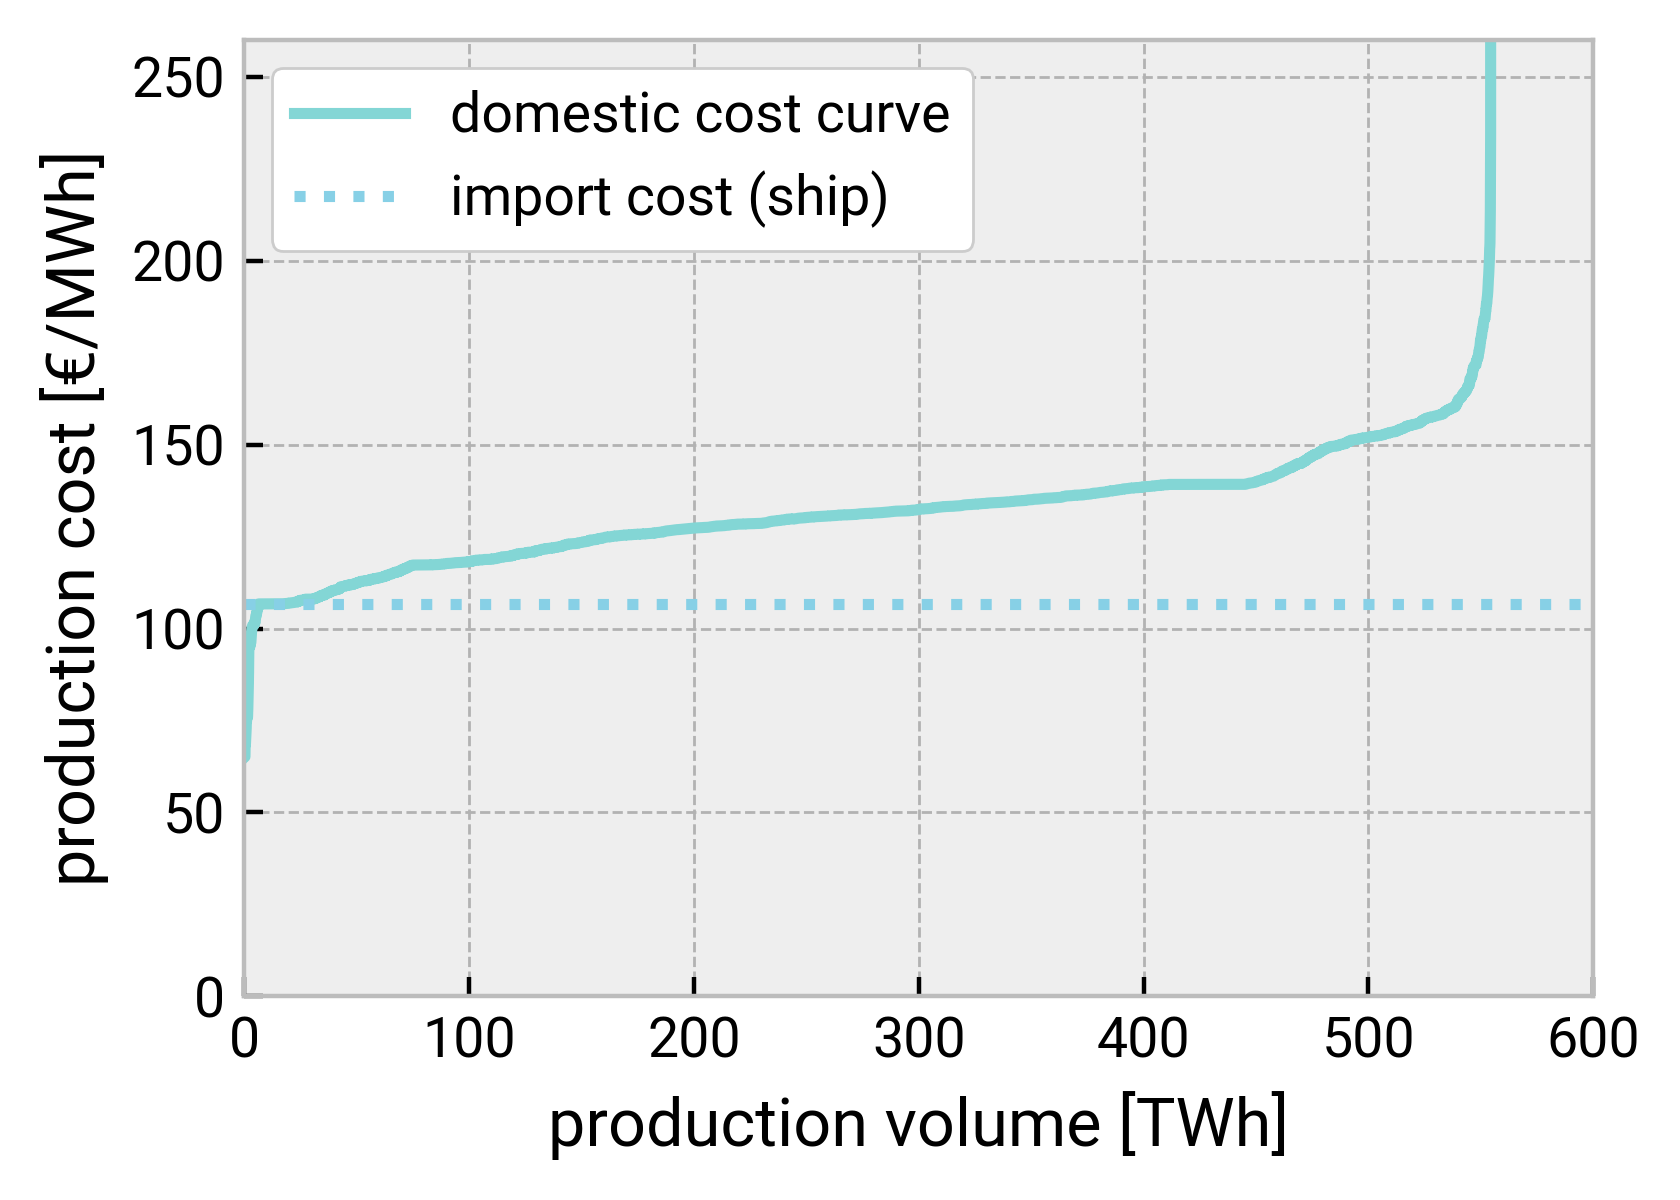

In [1713]:
csc = pd.concat({
    "mv": meoh_cost_t.stack(),
    "vol": meoh_meoh.mul(n.snapshot_weightings.generators, axis=0).stack().div(1e6), # TWh
}, axis=1).sort_values(by='mv').reset_index(drop=True)

csc['cum_vol'] = csc['vol'].cumsum()
fig, ax = plt.subplots(figsize=(4.3,3.1))
plt.plot(
    csc['cum_vol'],
    csc['mv'],
    marker='none',
    linestyle='-',
    color=tech_colors["methanolisation"],
    label="domestic cost curve"
)
plt.ylabel('production cost [€/MWh]')
plt.xlabel('production volume [TWh]')
ax.set_xlim(0, 600)
ax.set_ylim(0, 260)
ax.axhline(
    min_import_costs.at["methanol", "min"],
    color=tech_colors["import shipping-meoh"],
    label="import cost (ship)",
    linestyle=":",
)


plt.legend(frameon=True, facecolor='white', framealpha=1)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/csc-meoh-{scenario_name}{ext}", bbox_inches='tight')

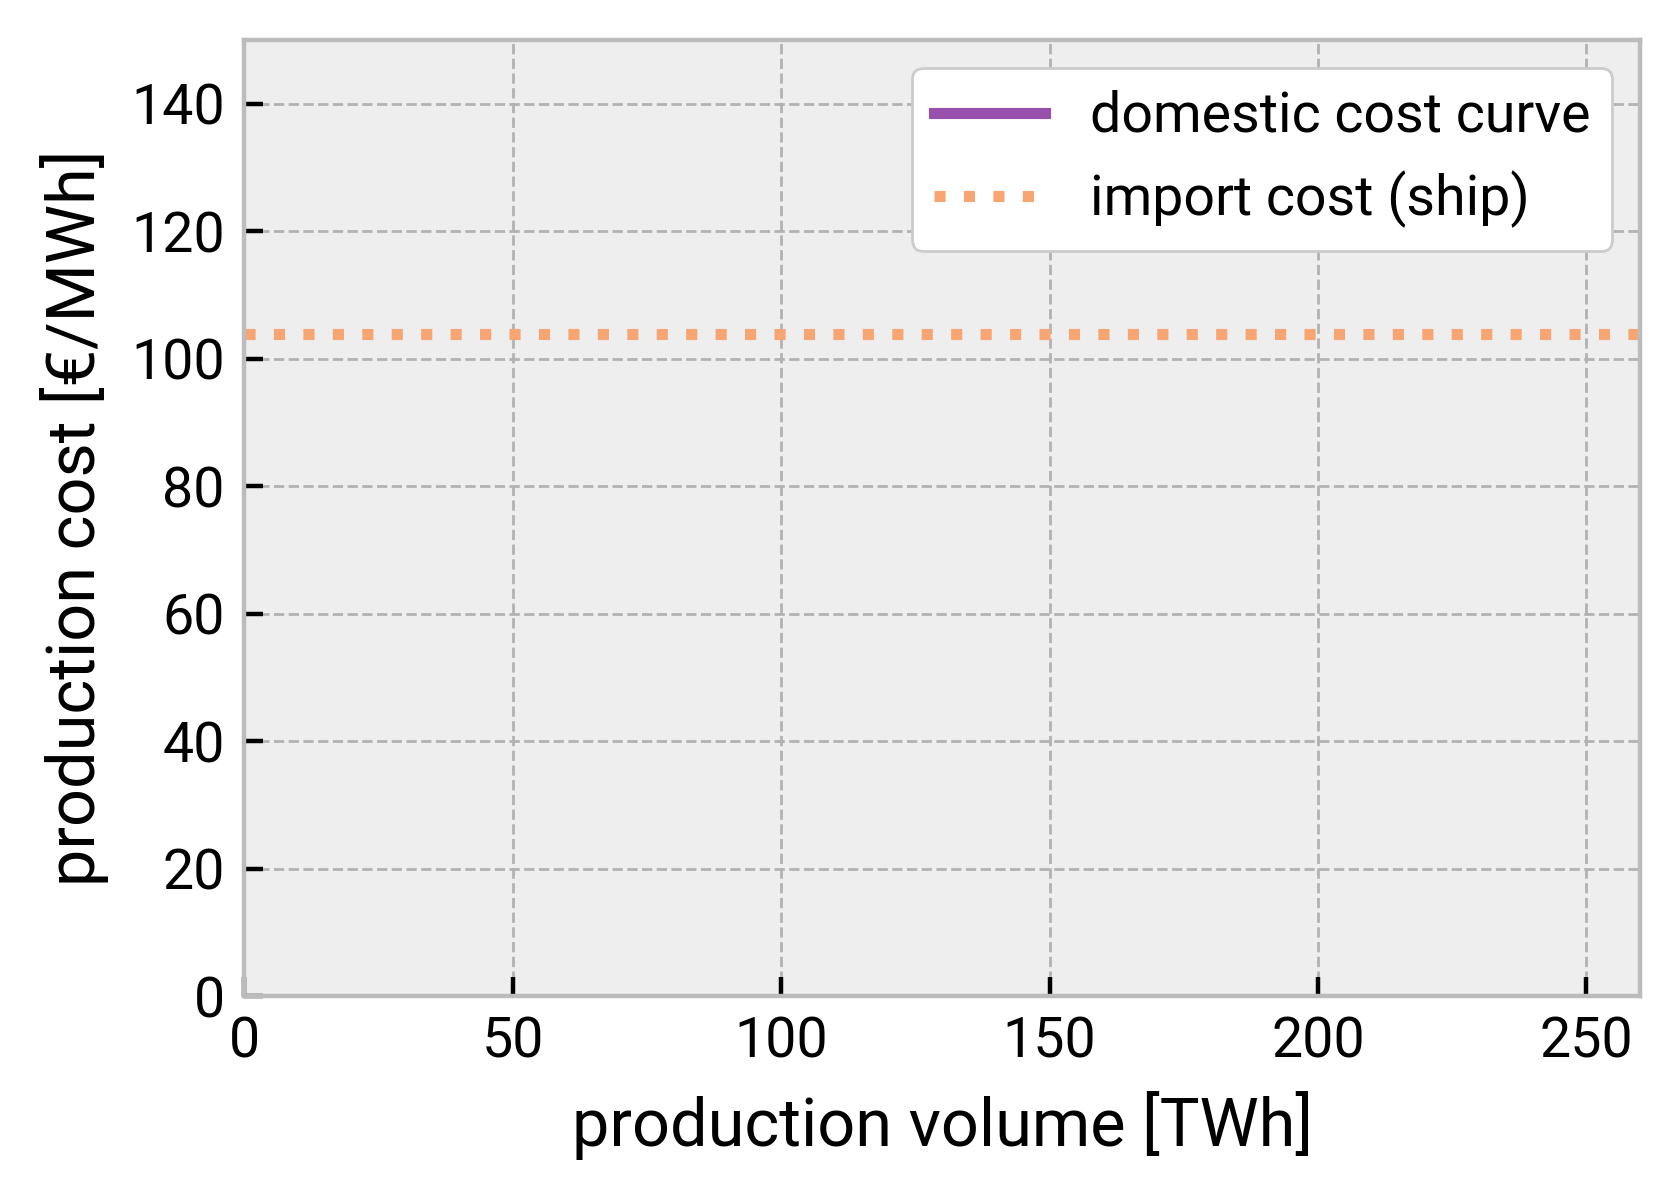

In [1714]:
csc = pd.concat({
    "mv": sab_cost_t.stack(),
    "vol": sab_gas.mul(n.snapshot_weightings.generators, axis=0).stack().div(1e6), # TWh
}, axis=1).sort_values(by='mv').reset_index(drop=True)

csc['cum_vol'] = csc['vol'].cumsum()
fig, ax = plt.subplots(figsize=(4.3,3.1))
plt.plot(
    csc['cum_vol'],
    csc['mv'],
    marker='none',
    linestyle='-',
    color=tech_colors["Sabatier"],
    label="domestic cost curve"
)
plt.ylabel('production cost [€/MWh]')
plt.xlabel('production volume [TWh]')
ax.set_xlim(0, 260)
ax.set_ylim(0, 150)
ax.axhline(
    min_import_costs.at["methane", "min"],
    color=tech_colors["import shipping-lch4"],
    label="import cost (ship)",
    linestyle=":",
)


plt.legend(frameon=True, facecolor='white', framealpha=1)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/csc-sab-{scenario_name}{ext}", bbox_inches='tight')